In [49]:
import geopandas as gpd
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import pandas as pd
import sys
import geopandas as gpd
%matplotlib inline

In [50]:
# walk root diretory to find and load .env file w/ AWS host, username and password
load_dotenv(find_dotenv())

True

In [51]:
# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("database"), user=os.environ.get("user"), 
                            password = os.environ.get("password"), 
                            host=os.environ.get("host"), port=os.environ.get("port"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [52]:
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)
        
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()

In [5]:
from geopandas import GeoSeries, GeoDataFrame

def gpd_query(QUERY):
    '''
    takes SQL query string, connects to postgres, and creates geopandas dataframe
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY+'\r\n')
        geo_df = GeoDataFrame.from_postgis(QUERY, 
        conn, geom_col='geom', crs={'init': u'epsg:4326'}, 
        coerce_float=False)
        
        print("created geopandas dataframe")
        return geo_df
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()

In [53]:
QUERY1='''SELECT *
FROM fmac_proportion;
'''

In [54]:
df1 = pquery(QUERY1)

Opened database successfully
SQL QUERY = SELECT *
FROM fmac_proportion;



In [55]:
QUERY2='''SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total, s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC
'''

In [9]:
#df2 = gpd_query(QUERY2)

In [56]:
QUERY3='''SELECT gid, fma, resp_zone, geom
FROM fblocks;
'''

In [57]:
df3 = gpd_query(QUERY3)

df3 = df3.rename(columns = {'resp_zone':'fireblock'})

Opened database successfully
SQL QUERY = SELECT gid, fma, resp_zone, geom
FROM fblocks;


created geopandas dataframe


In [58]:
df3.head()

,gid,fma,fireblock,geom
0,1,01,0103,(POLYGON ((-122.6739595339999 45.5319685220000...
1,2,01,0106,"(POLYGON ((-122.669984655 45.52957948400007, -..."
2,3,01,0109,"(POLYGON ((-122.669181766 45.52755928500005, -..."
3,4,01,0111,"(POLYGON ((-122.666151838 45.52710833500004, -..."
4,5,01,0112,"(POLYGON ((-122.664736116 45.52866324200005, -..."


In [59]:
df3.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 4 columns):
gid          578 non-null int64
fma          578 non-null object
fireblock    578 non-null object
geom         578 non-null object
dtypes: int64(1), object(3)
memory usage: 18.1+ KB


In [60]:
#df3_noGeom = df3.drop('geom', axis=1)
#df3_noGeom.head()
#df3_noGeom.to_csv("fireblocks_noGeom.csv")

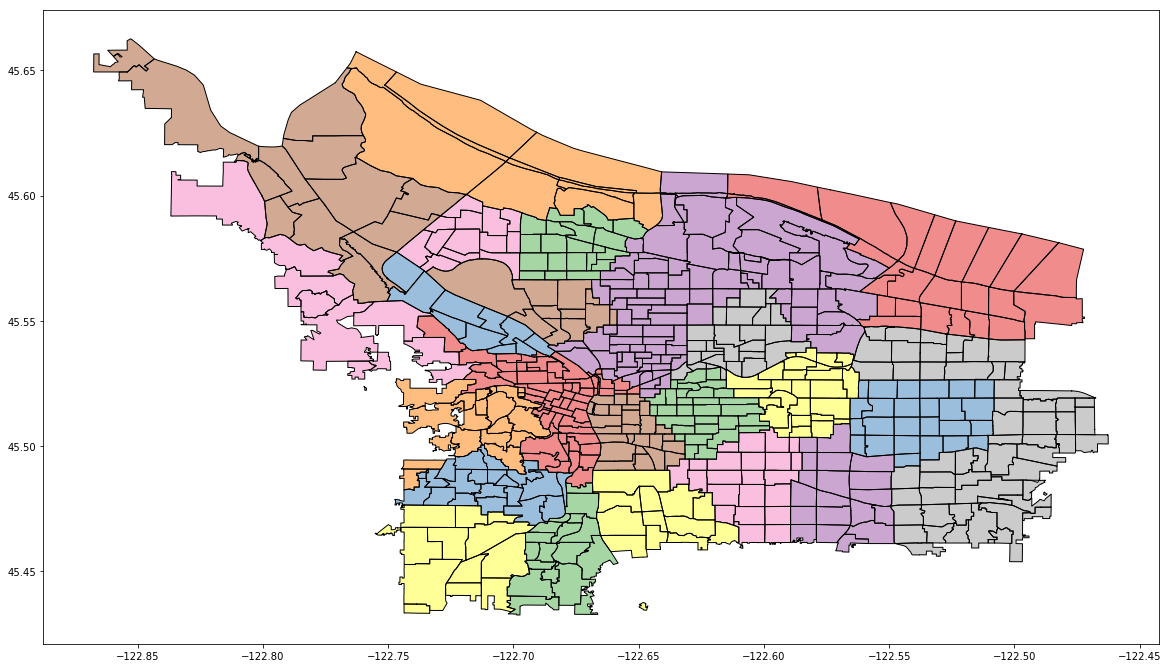

In [61]:
#df3.info()
df3.plot(figsize=(20,20), column='fma')

In [62]:
QUERY4='''SELECT incident.incident_id,incident.fireblock, incsitfoundclass.incsitfoundclass_id, incsitfoundclass.description
FROM incident
  INNER JOIN incsitfound
    ON incident.incsitfoundprm_id = incsitfound.incsitfound_id
  LEFT JOIN incsitfoundsub
    ON incsitfound.incsitfoundsub_id = incsitfoundsub.incsitfoundsub_id
  LEFT JOIN incsitfoundclass
    ON incsitfoundsub.incsitfoundclass_id = incsitfoundclass.incsitfoundclass_id;
'''

In [63]:
df4 = pquery(QUERY4)

Opened database successfully
SQL QUERY = SELECT incident.incident_id,incident.fireblock, incsitfoundclass.incsitfoundclass_id, incsitfoundclass.description
FROM incident
  INNER JOIN incsitfound
    ON incident.incsitfoundprm_id = incsitfound.incsitfound_id
  LEFT JOIN incsitfoundsub
    ON incsitfound.incsitfoundsub_id = incsitfoundsub.incsitfoundsub_id
  LEFT JOIN incsitfoundclass
    ON incsitfoundsub.incsitfoundclass_id = incsitfoundclass.incsitfoundclass_id;



In [64]:
df4.head()

,incident_id,fireblock,incsitfoundclass_id,description
0,1089329,3015,5,SERVICE CALL
1,1089330,2609,3,MEDICAL AID / RESCUE CALLS
2,1089331,0818,4,HAZARDOUS CONDITIONS
3,1089332,1397,1,FIRE/EXPLOSION
4,1089333,0109,3,MEDICAL AID / RESCUE CALLS


In [65]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512281 entries, 0 to 512280
Data columns (total 4 columns):
incident_id            512281 non-null int64
fireblock              512186 non-null object
incsitfoundclass_id    512281 non-null int64
description            512281 non-null object
dtypes: int64(2), object(2)
memory usage: 15.6+ MB


In [66]:
falsecalls_df = df4[df4['incsitfoundclass_id'] == 7]
falsecalls_df.info()

# 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39210 entries, 6 to 512274
Data columns (total 4 columns):
incident_id            39210 non-null int64
fireblock              39204 non-null object
incsitfoundclass_id    39210 non-null int64
description            39210 non-null object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [67]:
sf1 = falsecalls_df.groupby(['fireblock'])['incsitfoundclass_id'].count()

#what are the non-number fireblock id's?

In [68]:
df5 = sf1.to_frame().reset_index()
df5.columns = ['fireblock', 'FalseCall_Count']

In [69]:
#Push to csv
#df5.to_csv("falsecalls.csv")
#df3.to_csv("fireblocks.csv")

In [70]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 2 columns):
fireblock          716 non-null object
FalseCall_Count    716 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


In [42]:
#pd.merge(df3, df5, on='fireblock', how='inner')

df3.reset_index()
df5.reset_index()

dt6 = pd.merge(left=df3,right=df5,  how='left', left_on='fireblock', right_on='fireblock', suffixes=('_left', '_right'))